In [ ]:
# This codes downloads data from NASA's EarthData

In [1]:
import numpy as np
import pandas as pd

import requests

import netCDF4
from netCDF4 import Dataset
import h5py
import xarray as xr

import glob
import os
import calendar
import time

import sys
from math import floor, ceil
from pydap.client import open_url
from pydap.cas.urs import setup_session
from geostack.readers import ncutils
from time import time
from time import sleep
import lxml.etree
import datetime, calendar

from multiprocessing.pool import ThreadPool as Pool
import concurrent.futures
import itertools


import math
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Function to read data from the NASA GES DISC THREDDS SERVER
1. Uses the pydap client from geostack - https://gitlab.com/geostack
2. Retrieves data for a specified subregion 
3. Averages the rainfall for the defined subregion to return the average rainfall at each timestep
4. Uses concurrent futures to run 3 instances in parallel
5. Retries the data retrieval in case of failure (10 retries)

In [ ]:
# Enter NASA Earthdata username and password as a string
# https://urs.earthdata.nasa.gov
username = #'username'
password = #'password'

In [2]:
### Basic function refined to run with concurrent futures
def readDataFromThredds(year,day):

    # create a pydap object
    data_url = "https://gpm1.gesdisc.eosdis.nasa.gov/thredds/dodsC/aggregation/GPM_3IMERGHH.06/"+str(year)+"/GPM_3IMERGHH.06_Aggregation_"+str(year)+str("{:03d}".format(day))+".ncml.ncml"
    
    for attempt in range(10):
        try:
            # need to specify username and password in the line below
            session = setup_session(username, password, check_url=data_url)

            # open thredds data
            filepath = open_url(data_url, session=session)

            # create the dap object
            dap_obj = ncutils.Pydap2NC(filepath)

            # get latitude and longitude limits
            lon_lim = np.where((dap_obj.variables['lon'][:]>=xmin) & (dap_obj.variables['lon'][:]<=xmax))[0]
            lat_lim = np.where((dap_obj.variables['lat'][:]>=ymin) & (dap_obj.variables['lat'][:]<=ymax))[0]

            # read the precipitation data
            out = dap_obj.variables['precipitationCal'][:,lon_lim[0]:lon_lim[-1],lat_lim[0]:lat_lim[-1]]

            # get the average for each 30 minute timestep
            out_mean = np.mean(np.mean(out,axis=1),axis=1)
            output = [day,out_mean]
            return(output)

        except:
            print('Attempt '+str(attempt)+'failed, retrying: ', data_url)
            sleep(2)
        
        else:
            break
            
    else:
        print('Error: Failed all 10 attempts ', data_url)
        out_mean = [day,0]
        return(out_mean)
        pass  
        

6. Save a csv file with rainfall data for each of the defined years

In [ ]:
# Save one csv for each year
##### Define inputs
#start time
t0 = time()
## bounding box for required data
xmin = 100.134
xmax = 100.963
ymin = 13.4737
ymax = 14.1804

# required years
years = np.arange(2000,2021)
#years = [2011,2012]

for year in years:
    
    dfTotalPrecipitation = pd.DataFrame(columns=['year', 'day', 'timestep','precipitation (mm/hr)', \
                                             'total precipitation - 30 min (mm)'])

    if (year==2020):
        days = np.arange(1,121+1)
    elif (year==2000):
        days = np.arange(153,366+1)
    else:
        days = np.arange(1,365 + (1*calendar.isleap(year) + 1))
        
    #for day in days:
    #daily_rainfall = readDataFromThredds(year,day)
    with concurrent.futures.ThreadPoolExecutor(3) as executor:
        args = ((year,day) for day in days)

        dfList = [] 
        for result in executor.map(lambda p: readDataFromThredds(*p), args):
            #print(result)
            rainfallData = result[1]
            for precipIndex in range(len(rainfallData)):
                 dictionary = {'year':year, 'day':result[0], 'timestep':int(precipIndex),'precipitation (mm/hr)':rainfallData[precipIndex], \
                                                              'total precipitation - 30 min (mm)':rainfallData[precipIndex]*0.5}
                 dfTotalPrecipitation = dfTotalPrecipitation.append(dictionary,ignore_index=True,sort=False)
                 #dfList.append(dictionary)

            t1 = time()-t0
            print(year,result[0],np.shape(result[1]),t1)

    # Save the dataframe into a csv
    csvFileName = 'TotalPrecipitation'+'-'+str(year)+'.csv'
    dfTotalPrecipitation.to_csv(csvFileName)
    print('saved '+csvFileName)

7. Use the saved csv files with rainfall data for processing and plotting results

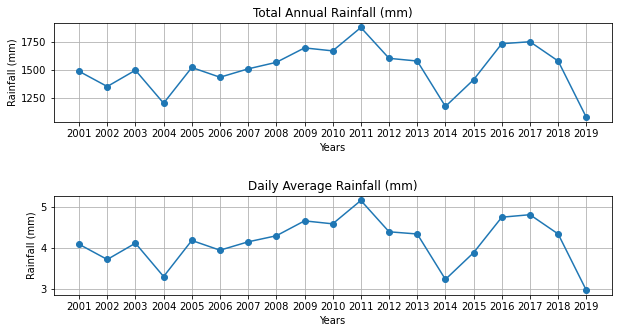

In [3]:
# Define the years for which, data are available
years = np.arange(2001,2020)

# create empty array for storing yearly maximums (rows=years, colums=durations)
# years = 2000, 2001.......2020
# durations = 30min, 1hr, 2hr, 6hr, 12hr, 24hr, 48hr
yearlyDailySum = []
yearlyDailyMean = []

for year in range(len(years)):
    fileName = 'TotalPrecipitation-'+str(years[year])+'.csv'
    yearData = pd.read_csv(fileName)
    yearlyVals = yearData.groupby([pd.cut(yearData['Unnamed: 0'],np.arange(-1,yearData['Unnamed: 0'].iloc[-1],48))])['total precipitation - 30 min (mm)'].agg('sum')
    yearlyDailySum.append(np.sum(yearlyVals))
    yearlyDailyMean.append(np.mean(yearlyVals))
    
# Create thte figure and plot the data
fig, axs = plt.subplots(2,1,figsize=(10,5))
fig.subplots_adjust(hspace = 0.75)
axs[0].plot(years,yearlyDailySum,'o-')
axs[0].set_xticks(years)
axs[0].grid(b=True, which='major', linestyle='-')
axs[0].set_title('Total Annual Rainfall (mm)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].set_xlabel('Years')

axs[1].plot(years,yearlyDailyMean,'o-')
axs[1].set_xticks(years)
axs[1].grid(b=True, which='major', linestyle='-')
axs[1].set_title('Daily Average Rainfall (mm)')
axs[1].set_ylabel('Rainfall (mm)')
axs[1].set_xlabel('Years')

fig.savefig('Yearly Stats '+str(years[0])+'_'+str(years[-1])+'.png',dpi=600)


8. Extract the yearly maximum rainfall values from the saved csv files

In [2]:
def returnMaxValues(dataFile,timeStepLengths):
    yearData = pd.read_csv(dataFile)
    
    # data are saved in timesteps of 30min each (q timestep for each 30 min)
    #therefore, 30min=1, 1hr=2, 2hr=4, 6hr=12, 12hr=24, 24hr=48
    timeStepLengths = timeStepLengths
    
    # array to save the maximum values for each duration
    maxValue = []
    
    # extract value ranges for each of the durations and return the maximum for each duration
    for t in timeStepLengths:
        #dataDuration = yearData.groupby(['day',pd.cut(yearData['timestep'],np.arange(-1,49,int(t)))])['total precipitation - 30 min (mm)'].agg('sum')
        dataDuration = hourlyData = yearData.groupby([pd.cut(yearData['Unnamed: 0'],np.arange(-1,yearData['Unnamed: 0'].iloc[-1],int(t)))])['total precipitation - 30 min (mm)'].agg('sum')
        
        maxValue.append(max(dataDuration))
        
    return maxValue
            

In [3]:
# Define the years for which, data are available
years = np.arange(2001,2020)

# required rainfall durations (in hours)
durations = [0.5,1,2,4,6,8,12,24,48]
#totalRainfallToRateFactor = [2,1,1/2,1/4,1/6,1/8,1/12,1/24,1/48]
totalRainfallToRateFactor = [1/d for d in durations]
#timeStepLengths = [1, 2, 4,8, 12,16, 24, 48, 96]
timeStepLengths = [d*2 for d in durations]

# create empty array for storing yearly maximums (rows=years, colums=durations)
# rows = years = 2000, 2001.......2020
# columns = durations = 30min, 1hr, 2hr, 6hr, 12hr, 24hr, 48hr
yearlyMaximums = np.zeros((len(years),len(durations)))

for year in range(len(years)):
    fileName = 'TotalPrecipitation-'+str(years[year])+'.csv'
    maxVals = returnMaxValues(fileName,timeStepLengths)
    yearlyMaximums[year] = maxVals
    
#print(yearlyMaximums)

9. Generate IFD Curves using the theoretical EV distibution approach - https://www.engr.colostate.edu/~ramirez/ce_old/classes/cive322-Ramirez/IDF-Procedure.pdf 

10. Plot the IFD Curves in mm and mm/hr vs durations

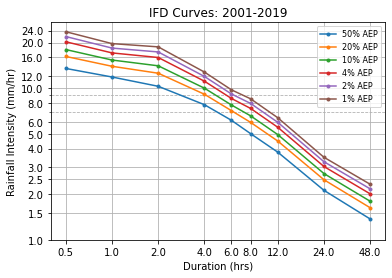

In [25]:
# Generating the IFD plot
# Using the theoretical extreme value (EV) distribution approach
# Gumbel Type 1 distribution

## Step 1 - frequency factors(KT) for the required return periods(T)
# Required return periods (T)
T = [2,5,10,25,50,100]

# frequency factors (KT)
Kt = [(-(np.sqrt(6)/np.pi))*(0.5722+math.log(math.log(t/(t-1)))) for t in T]
#print(Kt)

## Step 2 - sample mean and sample standard deviation for each duration
sampleMean = [np.mean(yearlyMaximums[:,y]) for y in range(len(durations))]
sampleSTD = [np.std(yearlyMaximums[:,y]) for y in range(len(durations))]
#print(sampleMean, sampleSTD)

## Step 3 - Compute precipitation intensity (Xt) associated with each return period
# Xt = mean + Kt*std
# Array with (rows=durations, columns=return periods(T))
# rows = durations = 30min, 1hr, 2hr, 6hr, 12hr, 24hr
# columns = T - 2, 5, 10, 25, 50, 100

Xt = np.zeros((len(durations),len(T)))
XtRate = np.zeros((len(durations),len(T)))

for d in range(len(durations)):
    for t in range(len(T)):
        Xt[d,t] = sampleMean[d] + Kt[t]*sampleSTD[d]
        XtRate[d,t] = (sampleMean[d] + Kt[t]*sampleSTD[d])*totalRainfallToRateFactor[d]
        
## Step 4 - plot the results
fig, ax = plt.subplots()


ax.plot(durations,XtRate,'.-')
plt.title('IFD Curves: '+str(years[0])+'-'+str(years[-1]))
plt.xlabel('Duration (hrs)')
plt.ylabel('Rainfall Intensity (mm/hr)')
# ax.legend(('Return Period = 2 years','Return Period = 5 years', 'Return Period = 10 years'\
#            ,'Return Period = 25 years','Return Period = 50 years','Return Period = 100 years',
#           ),fontsize=8)
ax.legend(('50% AEP','20% AEP', '10% AEP'\
           ,'4% AEP','2% AEP','1% AEP', \
          ),fontsize=8,loc='top right')
plt.xticks(np.linspace(0,48,13))
#plt.yticks(np.arange(0,120,10))
#plt.yticks([2,4,6,8,10,12,14,16,18,20,22,24,26])
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')

#### y axis (log scale)
plt.yscale('log')
ax.set_yticks([1,1.5,2,2.5,3,4,5,6,8,10,12,16,20,24])
# ax.set_yticks([1,2,4,6,8,12,16,20,24])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

# plt.yticks([0,1,2,3,4,5,10,20,30,100,150])

#### x axis (log2 scale)
plt.xscale('log', basex=2)
ax.set_xticks([0.5,1,2,4,6,8,12,24,48])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

plt.savefig('IFD Curve-'+str(years[0])+'_'+str(years[-1])+'.png',dpi=600)

[[  6.74635643   8.0948512    8.98767208  10.11575362  10.95262895
   11.78332493]
 [ 11.84960741  13.94408427  15.33081019  17.08294207  18.3827736
   19.67300737]
 [ 20.57765857  25.09444453  28.08494985  31.86346124  34.66657685
   37.44899469]
 [ 31.11508337  36.4554946   39.99131151  44.45882556  47.77308268
   51.06286786]
 [ 36.80833816  42.61076114  46.45247004  51.30647942  54.90746086
   58.48185322]
 [ 40.0712693   47.55566676  52.51098912  58.77205205  63.41686621
   68.02738378]
 [ 45.4373305   53.78757118  59.31615708  66.30154003  71.48369614
   76.62758803]
 [ 50.88496875  59.7596726   65.63549877  73.05962071  78.56725847
   84.0342287 ]
 [ 65.85402997  78.10001675  86.20792555  96.45228981 104.05214444
  111.59588294]]


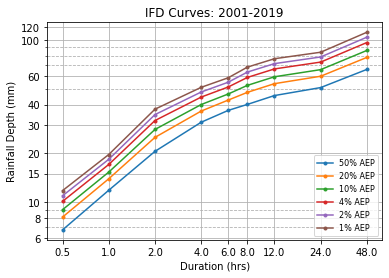

In [7]:
## Step 4 - plot the results ( in log scale)
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.plot(durations,Xt,'.-')
plt.title('IFD Curves: '+str(years[0])+'-'+str(years[-1]))
plt.xlabel('Duration (hrs)')
# plt.ylabel('Rainfall Intensity (mm/hr)')
plt.ylabel('Rainfall Depth (mm)')
# ax.legend(('Return Period = 2 years','Return Period = 5 years', 'Return Period = 10 years'\
#            ,'Return Period = 25 years','Return Period = 50 years','Return Period = 100 years',
#           ),fontsize=8)
ax.legend(('50% AEP','20% AEP', '10% AEP'\
           ,'4% AEP','2% AEP','1% AEP',\
          ),fontsize=8,loc='lower right')
#plt.xticks(np.linspace(0,48,13))

#### y axis (log scale)
plt.yscale('log')
ax.set_yticks([6,8,10,15,20,30,40,60,100,120])
# ax.set_yticks([1,2,4,6,8,12,16,20,24])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

# plt.yticks([0,1,2,3,4,5,10,20,30,100,150])

#### x axis (log2 scale)
plt.xscale('log', basex=2)
ax.set_xticks([0.5,1,2,4,6,8,12,24,48])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

#plt.yticks(np.arange(0,120,10))
#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')

plt.savefig('IFD Curve-'+str(years[0])+'_'+str(years[-1])+'.png',dpi=600)

print(Xt)

11. Plot IFD curves using the Empirical Plotting Position Approach

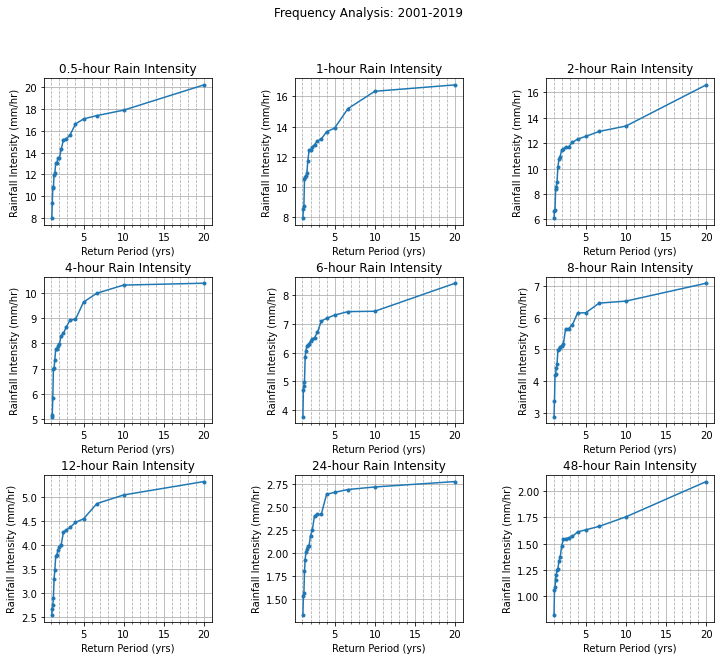

In [27]:
#### Using the Empirical Plotting Position Approach
## Step 1 -  Rank the observations in descending order (per duration)

## Step 2- Compute the exceedance probability for each rainfall
# p = 1/T = rank/(m+1) : m=no. of observations, T=return period, p=EP

## Step 3 - transform volume data into rainfall intensity 

## Step 4 - Plot empirical distribution of rainfall intensity

fig, axs = plt.subplots(3,3, figsize=(12,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=.5)
axs = axs.ravel()

for duration in range(len(durations)):
    durationMax = yearlyMaximums[:,duration]
    durationMax = np.sort(durationMax)
    durationMaxRate = [dm * totalRainfallToRateFactor[duration] for dm in durationMax]
    
    m = len(durationMax)
    T = [(m+1)/(i+1) for i in range(len(durationMax))]
    
    axs[duration].plot(np.flip(T),durationMaxRate,'.-')
    axs[duration].set_title(str(durations[duration])+'-hour Rain Intensity')
    #axs[duration].set_xticks(np.linspace(0,100,5))
    axs[duration].set_xlabel('Return Period (yrs)')
    axs[duration].set_ylabel('Rainfall Intensity (mm/hr)')
    #axs[duration].set_yticks(np.arange(0,14,1))
    #print(T,np.flip(durationMaxRate))
    axs[duration].xaxis.set_minor_locator(MultipleLocator(1))
    axs[duration].grid(b=True, which='major', linestyle='-')
    axs[duration].grid(b=True, which='minor', linestyle='--')
    
    #print(durationMax)
fig.suptitle('Frequency Analysis: '+str(years[0])+'-'+str(years[-1]))
plt.savefig('FrequencyAnalysis'+str(years[0])+'_'+str(years[-1])+'.png',dpi=600)
